In [1]:
import hashlib
import os
import sys
from os.path import realpath, join, dirname
import re
import numpy as np
import pandas as pd
import tensorflow as tf
import torch
from keras.layers import Dense, Input,InputLayer
from keras.models import Sequential
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.keras.models import load_model
import torch
from torch import nn, optim
from sklearn.preprocessing import StandardScaler
import numpy as np
import os
from transformers import (
    AutoTokenizer,
    TrainingArguments,
    AutoModelForSequenceClassification,
    set_seed,
)
sys.path.insert(0, realpath(join(dirname('captum_t.py'), '..')))

from util.helpers import (
    compute_metrics,
    load_dataset_with_features, get_hugging_face_name, TCCDataset, RegressionTrainer,
    compute_metrics_for_regression, OptimizedESCallback
)

os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'


MODEL_NAME = 'gbert'



gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
EXPERIMENT_NAME = f'ensemble_{MODEL_NAME}'
EXPERIMENT_DIR = f'../autodl-tmp/cache/{EXPERIMENT_NAME}'



2025-05-16 17:55:52.909091: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-16 17:55:52.928457: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-16 17:55:52.950469: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-16 17:55:52.956939: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-16 17:55:52.975129: I tensorflow/core/platform/cpu_feature_guar

In [2]:
def custom_forward(inputs):
    preds = predict(inputs)
    print(preds)
    return preds

In [3]:
def predict(inputs):
    #print('model(inputs): ', model(inputs))
    return model(inputs)[0]
def construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id):

    text_ids = tokenizer.encode(text, add_special_tokens=False)
    # construct input token ids
    input_ids = [cls_token_id] + text_ids + [sep_token_id]
    # construct reference token ids 
    ref_input_ids = [cls_token_id] + [ref_token_id] * len(text_ids) + [sep_token_id]

    return torch.tensor([input_ids], device=device), torch.tensor([ref_input_ids], device=device), len(text_ids)

def construct_input_ref_token_type_pair(input_ids, sep_ind=0):
    seq_len = input_ids.size(1)
    token_type_ids = torch.tensor([[0 if i <= sep_ind else 1 for i in range(seq_len)]], device=device)
    ref_token_type_ids = torch.zeros_like(token_type_ids, device=device)# * -1
    return token_type_ids, ref_token_type_ids

def construct_input_ref_pos_id_pair(input_ids):
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
    # we could potentially also use random permutation with `torch.randperm(seq_length, device=device)`
    ref_position_ids = torch.zeros(seq_length, dtype=torch.long, device=device)

    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
    ref_position_ids = ref_position_ids.unsqueeze(0).expand_as(input_ids)
    return position_ids, ref_position_ids
    
def construct_attention_mask(input_ids):
    return torch.ones_like(input_ids)

In [4]:

tokenizer = AutoTokenizer.from_pretrained(get_hugging_face_name(MODEL_NAME))
ref_token_id = tokenizer.pad_token_id # A token used for generating token reference
sep_token_id = tokenizer.sep_token_id # A token used as a separator between question and text and it is also added to the end of the text.
cls_token_id = tokenizer.cls_token_id # A token used for prepending to the concatenated question-text word sequence

In [5]:
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from captum.attr import visualization as viz
from captum.attr import IntegratedGradients, LayerConductance, LayerIntegratedGradients
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer
import torch
import matplotlib.pyplot as plt
import captum
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained(
                f'{EXPERIMENT_DIR}/models/{MODEL_NAME}/3221b14132ce1811b5cd73c4108382bd480e30138c2fadf6908e413349c00d49_gbert-large', local_files_only=True, num_labels=1
            ).to(device)

lig = LayerIntegratedGradients(custom_forward, model.bert.embeddings)

In [6]:
text =  "Kochbücher propagierten ab 1651 die „Haute Cuisine“, die von den ersten Restaurants fortan adaptiert wurde." #"The movie was one of those amazing movies"#"The movie was one of those amazing movies you can not forget"


In [7]:
##saved_act = None
def save_act(module, inp, out):
  #global saved_act
  saved_act = out
  return saved_act

hook = model.bert.embeddings.register_forward_hook(save_act)

def construct_whole_bert_embeddings(input_ids, ref_input_ids, \
                                    token_type_ids=None, ref_token_type_ids=None, \
                                    position_ids=None, ref_position_ids=None):
    input_embeddings = model.bert.embeddings(input_ids, token_type_ids=token_type_ids, position_ids=position_ids)
    ref_input_embeddings = model.bert.embeddings(ref_input_ids, token_type_ids=ref_token_type_ids, position_ids=ref_position_ids)
    
    return input_embeddings, ref_input_embeddings
def squad_pos_forward_func2(input_emb, attention_mask=None, position=0):
    pred = model(inputs_embeds=input_emb, attention_mask=attention_mask, )
    pred = pred[position]
    return pred.max(1).values
#def summarize_attributions(attributions):
#    attributions = attributions.sum(dim=-1).squeeze(0)
#    attributions = attributions / torch.norm(attributions)
#    return attributions
if torch.__version__ >= '1.7.0':
    norm_fn = torch.linalg.norm
else:
    norm_fn = torch.norm
def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / norm_fn(attributions)
    return attributions

    


In [8]:
def topFromValue(xticklabels, values):
    # 合并token. '##'开头的单词
    # return top words and values.
    merged_words = []
    merged_values = []
    temp_word = ""
    temp_value = 0
    
    for word, value in zip(xticklabels, values):
        if word.startswith('##'):
            temp_word += word[2:]
            temp_value += value
        else:
            if temp_word:
                merged_words.append(temp_word)
                merged_values.append(temp_value)
                temp_word = ""
                temp_value = 0
            temp_word = word
            temp_value = value
    
    if temp_word:
        merged_words.append(temp_word)
        merged_values.append(temp_value)

    filtered = [(w, v) for w, v in zip(merged_words, merged_values)
                if re.search(r'[\w\u4e00-\u9fff]', w)]  # Filtering symbol

    if not filtered: 
        return [], []

    merged_words, merged_values = zip(*filtered)
    
    
    top_k = max(3, int(len(merged_values) * 0.3))  # At least three, but the number of difficult words is determined based on 30% of the total number of words.
    
    top_five_indices = sorted(range(len(merged_values)), key=lambda i: merged_values[i], reverse=True)[:top_k]
    top_five_words = [merged_words[i] for i in top_five_indices]
    top_five_values = [merged_values[i] for i in top_five_indices]
    
    #print("Top words :", top_five_words)
    #print("contribution values:", top_five_values)
    return top_five_words, top_five_values



In [17]:
def captumProcess(text,tokenizer, model, ref_token_id, sep_token_id, cls_token_id):
    # 对text进行embedding
    input_ids, ref_input_ids, sep_id = construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id)
    token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids, sep_id)
    position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
    attention_mask = construct_attention_mask(input_ids)
    
    indices = input_ids[0].detach().tolist()
    all_tokens = tokenizer.convert_ids_to_tokens(indices)
    layer_attrs_start = []
    layer_attrs_end = []
    
    
    
    layer_attrs_start_dist = []
    layer_attrs_end_dist = []
    
    input_embeddings, ref_input_embeddings = construct_whole_bert_embeddings(input_ids, ref_input_ids, \
                                             token_type_ids=token_type_ids, ref_token_type_ids=ref_token_type_ids, \
                                             position_ids=position_ids, ref_position_ids=ref_position_ids)
    
    for i in range(model.config.num_hidden_layers):
        lc = LayerConductance(squad_pos_forward_func2, model.bert.encoder.layer[i])
        layer_attributions_start = lc.attribute(inputs=input_embeddings, baselines=ref_input_embeddings)
        layer_attributions_end = lc.attribute(inputs=input_embeddings, baselines=ref_input_embeddings)
        layer_attrs_start.append(summarize_attributions(layer_attributions_start).cpu().detach().tolist())
        layer_attrs_end.append(summarize_attributions(layer_attributions_end).cpu().detach().tolist())
    values = np.mean(np.array(layer_attrs_start),axis=0) #
    xticklabels=all_tokens
    top_words, top_values = topFromValue(xticklabels, values)
    #print(top_words)
    return top_words, top_values

In [18]:
top_words, top_values = captumProcess(text,tokenizer, model, ref_token_id, sep_token_id, cls_token_id)


# stop here, the code above is about using captum to get the top contributed words and their contribution values.
# from below, the code is for calculating hitPercent

In [19]:
top_words, top_values

(['Haute', 'propagierten', '1651', 'fortan', 'die'],
 [0.4469438809222387,
  0.444574096684543,
  0.2496087642988035,
  0.24581056437455118,
  0.1479398519732058])

In [20]:
newtext = 'Ungeachtet der Umweltverhältnisse kam zu diesem Zeitpunkt die Chemische Evolution in Gang, bei der sich organische Moleküle bildeten, die als Bausteine der Entstehung von Leben unerlässlich waren.'

In [77]:
len(newtext.split(' '))

27

In [21]:
top_words, top_values = captumProcess(newtext,tokenizer, model, ref_token_id, sep_token_id, cls_token_id)

In [13]:
import json
with open("difficult_words.json", "r", encoding="utf-8") as f:
    difficult_dict = json.load(f)
with open("Final_ratings_table.json", "r", encoding="utf-8") as f:
    ratingTable = json.load(f)


In [14]:
ratingTable[0]

{'ID': 3,
 'Sentence': 'Etwa 5000 Jahre ist es her, seit die Sumerer das Sieden von Seife erfanden.',
 'MOS_R': 1.888888889,
 'MOS_U': 1.888888889,
 'MOS_L': 2.666666667}

In [23]:
def SingleHitPercent(text, tokenizer, model, ref_token_id, sep_token_id, cls_token_id):
    text = ratingTable[sampleIndex]['Sentence']
    try:
        top_words, top_values = captumProcess(text,tokenizer, model, ref_token_id, sep_token_id, cls_token_id)
        #print(top_words)
    except:
        #print(top_words)
        pass
    hit = 0
    #print(top_words)
    for word in top_words:
        try:
            if difficult_dict[word] == 1:
                hit += 1
        except:
            pass
    ratingTable[sampleIndex]['hitPercent'] = hit / len(top_words)
    ratingTable[sampleIndex]['top_words'] = top_words
    ratingTable[sampleIndex]['top_values'] =  top_values

In [81]:
from tqdm import tqdm

dealLength = min([20, len(ratingTable)]) # here we use 20 samples to test, because its quite slow to run all thousands samples. We can expand the scope later. 
for sampleIndex in tqdm(range(dealLength)):
    text = ratingTable[sampleIndex]['Sentence']
    MOS_R = ratingTable[sampleIndex]['MOS_R']
    try:
        top_words, top_values = captumProcess(text,tokenizer, model, ref_token_id, sep_token_id, cls_token_id)
        #print(top_words)
    except:
        #print(top_words)
        pass
    hit = 0
    #print(top_words)
    for word in top_words:
        try:
            if difficult_dict[word] == 1:
                hit += 1
        except:
            pass
    ratingTable[sampleIndex]['hitPercent'] = hit / len(top_words)
    ratingTable[sampleIndex]['top_words'] = top_words
    ratingTable[sampleIndex]['top_values'] =  top_values

100%|██████████| 20/20 [00:50<00:00,  2.52s/it]


In [82]:
ratingTable[2]

{'ID': 5,
 'Sentence': 'Wegen dieser leichten Vergänglichkeit wurde ,Seifenblase‘ zu einer Metapher für etwas, das zwar anziehend, aber dennoch inhalts- und gehaltlos ist.',
 'MOS_R': 4.428571429,
 'MOS_U': 4.0,
 'MOS_L': 4.214285714,
 'hitPercent': 0.5,
 'top_words': ['gehaltlos',
  'dieser',
  'Vergänglichkeit',
  'leichten',
  'und',
  'ist'],
 'top_values': [0.7669549693382578,
  0.281521899625659,
  0.20116414655543244,
  0.18473775126039982,
  0.16271022893488407,
  0.10974635677606177]}

In [83]:

# save the result.
json_path = "AdaptFinal_ratings_table.json"
with open(json_path, "w", encoding="utf-8") as f:
    json.dump(ratingTable, f, ensure_ascii=False, indent=4)


In [4]:
# read result
import json
json_path = "AdaptFinal_ratings_table.json"

with open(json_path,'r') as f:
    ratingTable_d = f.read()
ratingTable = json.loads(ratingTable_d)

    hitPercent     MOS_R     MOS_U     MOS_L
0     0.000000  1.888889  1.888889  2.666667
1     0.000000  1.600000  2.222222  3.200000
2     0.500000  4.428571  4.000000  4.214286
3     0.000000  3.300000  2.666667  3.300000
4     0.333333  4.000000  3.000000  4.428571
5     0.285714  3.444444  2.888889  3.750000
6     0.285714  5.000000  4.500000  5.100000
7     0.166667  3.444444  2.900000  4.000000
8     0.333333  2.900000  3.100000  4.285714
9     0.333333  1.666667  1.500000  2.500000
10    0.333333  4.833333  4.166667  4.611111
11    0.333333  5.700000  5.200000  6.000000
12    0.000000  2.666667  2.888889  3.111111
13    0.000000  2.777778  2.777778  2.777778
14    0.428571  4.200000  3.600000  5.000000
15    0.250000  3.750000  3.500000  3.666667
16    0.666667  3.500000  3.600000  4.700000
17    0.000000  4.400000  3.444444  4.600000
18    0.166667  2.555556  2.800000  3.400000
19    0.000000  3.333333  2.777778  3.444444

Spearman ：
             hitPercent     MOS_R     MOS_U

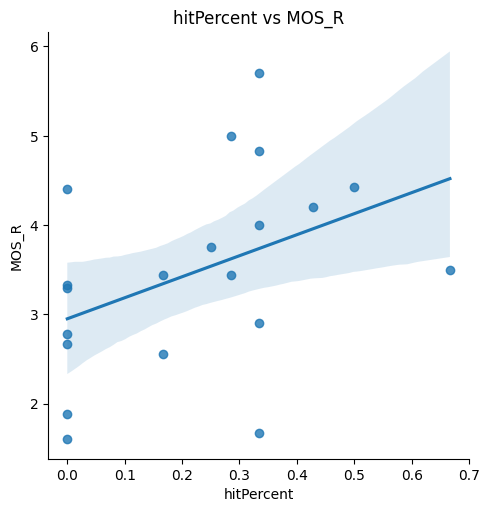

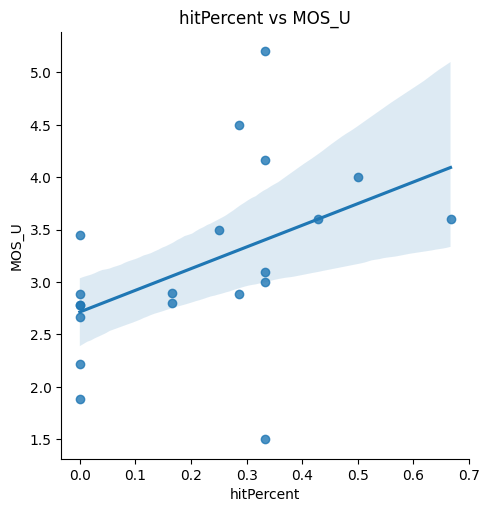

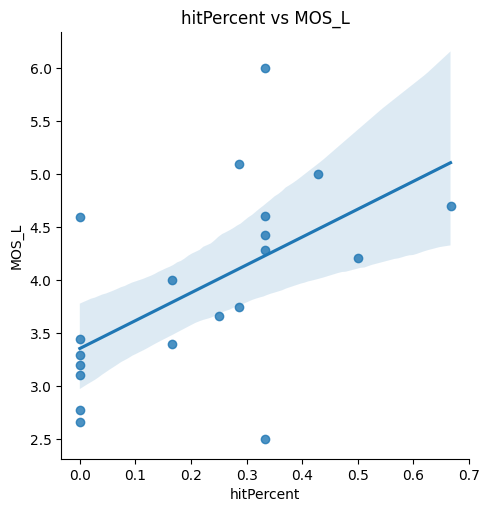

"\nResult:\n    hitPercent     MOS_R     MOS_U     MOS_L\n0     0.000000  1.888889  1.888889  2.666667\n1     0.000000  1.600000  2.222222  3.200000\n2     0.500000  4.428571  4.000000  4.214286\n3     0.000000  3.300000  2.666667  3.300000\n4     0.333333  4.000000  3.000000  4.428571\n5     0.285714  3.444444  2.888889  3.750000\n6     0.285714  5.000000  4.500000  5.100000\n7     0.166667  3.444444  2.900000  4.000000\n8     0.333333  2.900000  3.100000  4.285714\n9     0.333333  1.666667  1.500000  2.500000\n10    0.333333  4.833333  4.166667  4.611111\n11    0.333333  5.700000  5.200000  6.000000\n12    0.000000  2.666667  2.888889  3.111111\n13    0.000000  2.777778  2.777778  2.777778\n14    0.428571  4.200000  3.600000  5.000000\n15    0.250000  3.750000  3.500000  3.666667\n16    0.666667  3.500000  3.600000  4.700000\n17    0.000000  4.400000  3.444444  4.600000\n18    0.166667  2.555556  2.800000  3.400000\n19    0.000000  3.333333  2.777778  3.444444\n\nSpearman ：\n        

In [5]:
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
#for i in range(len(ratingTable)):
    
#    ratingTable[i]['hitPercent'] = str(int(ratingTable[i]['hitPercent']*10))

df = pd.DataFrame(ratingTable)
#print(df.head())  

cols = ["hitPercent", "MOS_R", "MOS_U", "MOS_L"]
df = df[cols].dropna()
df["MOS_R"] = df["MOS_R"]

print(df)  
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt


spearman_corr = df.corr(method='spearman')

print("\nSpearman ：\n", spearman_corr)

import seaborn as sns
import matplotlib.pyplot as plt


for col in ["MOS_R", "MOS_U", "MOS_L"]:
    sns.lmplot(data=df, x="hitPercent", y=col)
    plt.title(f"hitPercent vs {col}")
    plt.show()

'''
Result:
    hitPercent     MOS_R     MOS_U     MOS_L
0     0.000000  1.888889  1.888889  2.666667
1     0.000000  1.600000  2.222222  3.200000
2     0.500000  4.428571  4.000000  4.214286
3     0.000000  3.300000  2.666667  3.300000
4     0.333333  4.000000  3.000000  4.428571
5     0.285714  3.444444  2.888889  3.750000
6     0.285714  5.000000  4.500000  5.100000
7     0.166667  3.444444  2.900000  4.000000
8     0.333333  2.900000  3.100000  4.285714
9     0.333333  1.666667  1.500000  2.500000
10    0.333333  4.833333  4.166667  4.611111
11    0.333333  5.700000  5.200000  6.000000
12    0.000000  2.666667  2.888889  3.111111
13    0.000000  2.777778  2.777778  2.777778
14    0.428571  4.200000  3.600000  5.000000
15    0.250000  3.750000  3.500000  3.666667
16    0.666667  3.500000  3.600000  4.700000
17    0.000000  4.400000  3.444444  4.600000
18    0.166667  2.555556  2.800000  3.400000
19    0.000000  3.333333  2.777778  3.444444

Spearman ：
             hitPercent     MOS_R     MOS_U     MOS_L
hitPercent    1.000000  0.507781  0.626477  0.612983
MOS_R         0.507781  1.000000  0.912274  0.880782
MOS_U         0.626477  0.912274  1.000000  0.909297
MOS_L         0.612983  0.880782  0.909297  1.000000

The first list is about specific sample's hitPercent value and it's difficulty.
Spearman means the nonlinear correlation between variables.
Understanding difficulty is the most relevant variable to hitPercent. The reason behind this might be difficult words influence understanding most, but not reading and linguistic it self.

50% is good enough.
'''

Difficulty understanding AUC = 0.8333333333333333
Difficulty reading AUC = 0.7087912087912087
Difficulty linguistic AUC = 0.6666666666666667


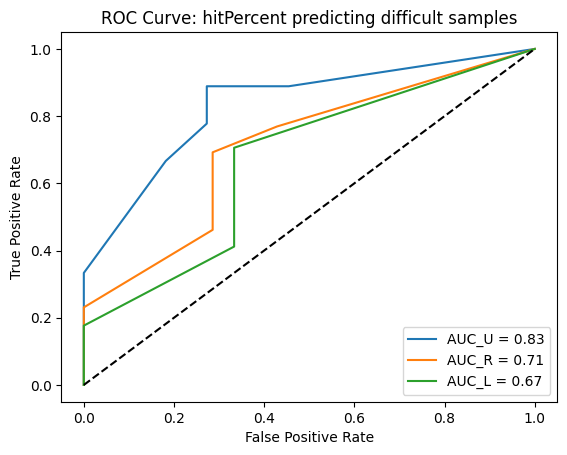

In [3]:
df["label_difficult_U"] = (df["MOS_U"] > 3).astype(int)  # 1 stand for easy, 0 stand for hard.
df["label_difficult_R"] = (df["MOS_R"] > 3).astype(int)  # 1 stand for easy, 0 stand for hard.
df["label_difficult_L"] = (df["MOS_L"] > 3).astype(int)  # 1 stand for easy, 0 stand for hard.

from sklearn.metrics import roc_auc_score


auc_U = roc_auc_score(df["label_difficult_U"], df["hitPercent"])
auc_R = roc_auc_score(df["label_difficult_R"], df["hitPercent"])
auc_L = roc_auc_score(df["label_difficult_L"], df["hitPercent"])

print("Difficulty understanding AUC =", auc_U)
print("Difficulty reading AUC =", auc_R)
print("Difficulty linguistic AUC =", auc_L)

from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr_U, tpr_U, _ = roc_curve(df["label_difficult_U"], df["hitPercent"])
fpr_R, tpr_R, _ = roc_curve(df["label_difficult_R"], df["hitPercent"])
fpr_L, tpr_L, _ = roc_curve(df["label_difficult_L"], df["hitPercent"])

plt.plot(fpr_U, tpr_U, label=f"AUC_U = {auc_U:.2f}")
plt.plot(fpr_R, tpr_R, label=f"AUC_R = {auc_R:.2f}")
plt.plot(fpr_L, tpr_L, label=f"AUC_L = {auc_L:.2f}")
plt.plot([0, 1], [0, 1], 'k--')  # baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: hitPercent predicting difficult samples")
plt.legend()
plt.show()

In [ ]:
# finished.

In [ ]:
import pandas as pd
import json
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
from tqdm import tqdm
# 读取 Excel 文件
file_path = "TextComplexityDE19.xlsx"
xls = pd.ExcelFile(file_path)

# 加载 Final_rating_table
sheet_name = "Final_Ratings_Table"  # 假设表名是这个，需要确认
df = xls.parse(sheet_name)

# 提取所需字段
columns_needed = ["ID", "Sentence", "MOS_R", "MOS_U", "MOS_L"]
df_selected = df[columns_needed]

# 转换为 JSON 格式
json_output = df_selected.to_dict(orient="records")

# 保存 JSON 文件
json_path = "Final_ratings_table.json"
with open(json_path, "w", encoding="utf-8") as f:
    json.dump(json_output, f, ensure_ascii=False, indent=4)

# 返回 JSON 预览
json_output[:5]  # 只展示前5条数据

In [ ]:
import nltk
difficult_words = {}
def extract_words(data):
    words = set()
    for entry in data:
        sentence = entry['Sentence']
        # 使用nltk进行德语单词的分词
        words_in_sentence = nltk.word_tokenize(sentence, language='german')
        words.update([word for word in words_in_sentence if word.isalpha()])  # 去重
    return words
def prepare_context(word, sentence):
    # 传递给API时，可以通过给定词汇的上下文帮助提高准确性
    context = f"Hier ist ein Beispiel für das Wort '{word}' in einem Satz: '{sentence}'"
    return context


word_difficulty = {}

# 提取去重后的所有单词
all_unique_words = extract_words(json_output)

print(len(all_unique_words))

In [ ]:
from tqdm import tqdm
def is_difficult_word(word_list, model_name="Qwen/Qwen2.5-3B"):
    # 加载模型和分词器
    tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir='/root/autodl-tmp')
    model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, device_map="auto", cache_dir='/root/autodl-tmp')
    
    results = {}
    for word in tqdm(word_list):
        #word ='spätestens'
        prompt = f"请帮我严格一点判断下面的德语词汇是否属于是高难词，这里判断高难词要考虑是否是较长复杂的复合词，是否是专业术语，是否是不常见的词汇。只回答is difficulty或is not difficult就行。下面有两个样例供你参考，你需要回答的只有Assistant后面的。Word: Vergänglichkeit. Assistant: This word is difficult. Word: Redewendung. Assistant: This word is not difficult. 上面是样例，下面是你要判断的词：Word: {word}"

        #prompt = f"Ist das deutsche Wort '{word}' ein schwieriges Wort? Antworte mit 'Ja' oder 'Nein'."
        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
        with torch.no_grad():
            outputs = model.generate(**inputs, max_new_tokens=10,
                                     do_sample=True,  # 采样生成
                                    temperature=0.4,  # 控制生成的多样性
                                    repetition_penalty=1.2)  # 降低复读概率)
        response = tokenizer.decode(outputs[0], skip_special_tokens=True)
        response = response.split('Assistant: ')[-1]
        print(response)
        if 'is difficult' in response:
            
            results[word] = 1
        else:
            results[word] = 0
    return results

In [ ]:
resultDict = is_difficult_word(all_unique_words)

In [ ]:
import json

# 假设 resultDict 已经生成
with open("difficult_words.json", "w", encoding="utf-8") as f:
    json.dump(resultDict, f, ensure_ascii=False, indent=4)  # 确保非 ASCII 字符（如德语字符）正常存储


In [58]:
# 将集合转换为列表
words_list = list(all_unique_words)

# 将列表转换为 JSON 格式的字符串
json_data = json.dumps(words_list, ensure_ascii=False, indent=4)

# 将 JSON 数据写入文件
with open('unique_words.json', 'w', encoding='utf-8') as file:
    file.write(json_data)

print("JSON 文件已保存。")

JSON 文件已保存。


In [60]:
# 将集合转换为列表
words_list = list(all_unique_words)

# 创建 DataFrame
df = pd.DataFrame(words_list, columns=["Word"])

# 保存到 Excel 文件
df.to_excel("unique_words.xlsx", index=False)

print("Excel 文件已保存。")

Excel 文件已保存。


In [57]:
word ='spätestens'
prompt = f"请帮我判断下面的德语词汇是否属于是高难词，只回答is difficulty或is not difficult就行。下面有两个样例供你参考，你需要回答的只有Assistant后面的。Word: Redewendung. Assistant: This word is difficult. Word: Vergänglichkeit. Assistant: This word is difficult. 下面是你要判断的词：Word: {word}"

output = api.run(
    "meta/llama-2-70b-chat:02e509c789964a7ea8736978a43525956ef40397be9033abf9fd2badfe68c9e3",
        input={"prompt": prompt,
              "max_new_tokens": 10}
    )
for item in output:
    print(item, end="")

 Assistant: This word is not difficult.

In [18]:
input_ids, ref_input_ids, sep_id = construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id)
token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids, sep_id)
position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
attention_mask = construct_attention_mask(input_ids)

indices = input_ids[0].detach().tolist()
all_tokens = tokenizer.convert_ids_to_tokens(indices)

In [19]:
##saved_act = None
def save_act(module, inp, out):
  #global saved_act
  saved_act = out
  return saved_act

hook = model.bert.embeddings.register_forward_hook(save_act)

In [20]:
# Check predict output
custom_forward(torch.cat([input_ids]).to(device))
input_ids.shape

tensor([[3.2616]], device='cuda:0', grad_fn=<AddmmBackward0>)


torch.Size([1, 29])

In [28]:
def construct_whole_bert_embeddings(input_ids, ref_input_ids, \
                                    token_type_ids=None, ref_token_type_ids=None, \
                                    position_ids=None, ref_position_ids=None):
    input_embeddings = model.bert.embeddings(input_ids, token_type_ids=token_type_ids, position_ids=position_ids)
    ref_input_embeddings = model.bert.embeddings(ref_input_ids, token_type_ids=ref_token_type_ids, position_ids=ref_position_ids)
    
    return input_embeddings, ref_input_embeddings
def squad_pos_forward_func2(input_emb, attention_mask=None, position=0):
    pred = model(inputs_embeds=input_emb, attention_mask=attention_mask, )
    pred = pred[position]
    return pred.max(1).values
#def summarize_attributions(attributions):
#    attributions = attributions.sum(dim=-1).squeeze(0)
#    attributions = attributions / torch.norm(attributions)
#    return attributions
if torch.__version__ >= '1.7.0':
    norm_fn = torch.linalg.norm
else:
    norm_fn = torch.norm
def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / norm_fn(attributions)
    return attributions
layer_attrs_start = []
layer_attrs_end = []



layer_attrs_start_dist = []
layer_attrs_end_dist = []

input_embeddings, ref_input_embeddings = construct_whole_bert_embeddings(input_ids, ref_input_ids, \
                                         token_type_ids=token_type_ids, ref_token_type_ids=ref_token_type_ids, \
                                         position_ids=position_ids, ref_position_ids=ref_position_ids)

for i in range(model.config.num_hidden_layers):
    lc = LayerConductance(squad_pos_forward_func2, model.bert.encoder.layer[i])
    layer_attributions_start = lc.attribute(inputs=input_embeddings, baselines=ref_input_embeddings)
    layer_attributions_end = lc.attribute(inputs=input_embeddings, baselines=ref_input_embeddings)
    layer_attrs_start.append(summarize_attributions(layer_attributions_start).cpu().detach().tolist())
    layer_attrs_end.append(summarize_attributions(layer_attributions_end).cpu().detach().tolist())


In [25]:
values = np.mean(np.array(layer_attrs_start),axis=0)
xticklabels=all_tokens

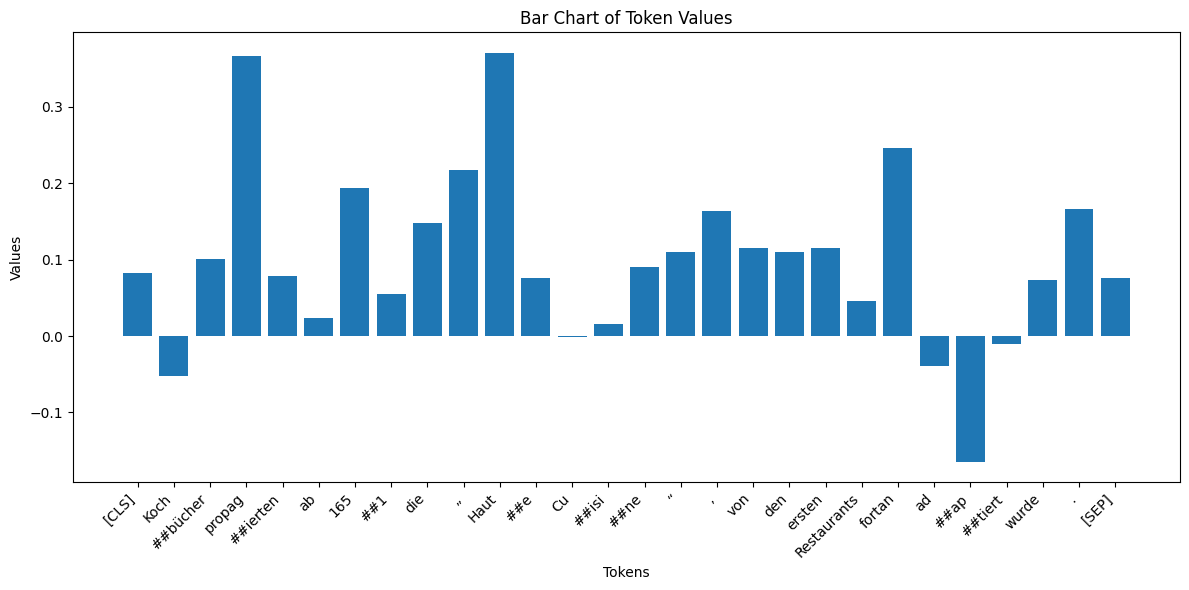

In [26]:
# 创建柱状图
plt.figure(figsize=(12, 6))
plt.bar(xticklabels, values)

# 添加标签和标题
plt.xlabel('Tokens')
plt.ylabel('Values')
plt.title('Bar Chart of Token Values')

# 旋转x轴标签以便更好地显示
plt.xticks(rotation=45, ha='right')

# 显示图形
plt.tight_layout()
plt.show()


In [27]:
# 合并'##'开头的单词
merged_words = []
merged_values = []
temp_word = ""
temp_value = 0

for word, value in zip(xticklabels, values):
    if word.startswith('##'):
        temp_word += word[2:]
        temp_value += value
    else:
        if temp_word:
            merged_words.append(temp_word)
            merged_values.append(temp_value)
            temp_word = ""
            temp_value = 0
        temp_word = word
        temp_value = value

if temp_word:
    merged_words.append(temp_word)
    merged_values.append(temp_value)

# 贡献值最大的前三项
top_five_indices = sorted(range(len(merged_values)), key=lambda i: merged_values[i], reverse=True)[:3]
top_five_words = [merged_words[i] for i in top_five_indices]
top_five_values = [merged_values[i] for i in top_five_indices]

print("Top five words :", top_five_words)
print("contribution values:", top_five_values)




Top five words : ['Haute', 'propagierten', '1651']
contribution values: [0.4469438809222387, 0.444574096684543, 0.2496087642988035]
